# Simple script for smoothing jagged psfs

In [1]:
import sys,os,os.path
sys.path.append("../../")   # cite IC from parent directory
                            # NOTE if you can't import IC stuff, its because of the
                            # above line
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

import os
import glob
import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt

from IC.invisible_cities.reco.psf_functions    import create_psf
from IC.invisible_cities.reco.psf_functions    import hdst_psf_processing
from IC.invisible_cities.reco.psf_functions    import add_empty_sensors_and_normalize_q
from IC.invisible_cities.reco.psf_functions    import add_variable_weighted_mean

import IC.invisible_cities.core.core_functions as     coref
import IC.invisible_cities.io  .dst_io         as     dstio

from IC.invisible_cities.database              import load_db
#from IC.invisible_cities.io      .kdst_io      import psf_writer
# he's dead jim, make psf_writer yourself

import functions as func

%load_ext autoreload
%autoreload 2

In [2]:
class PSFfactors(tb.IsDescription):
    nevt   = tb. UInt32Col(pos=0)
    xr     = tb.Float32Col(pos=1)
    yr     = tb.Float32Col(pos=2)
    zr     = tb.Float32Col(pos=3)
    x      = tb.Float32Col(pos=4)
    y      = tb.Float32Col(pos=5)
    z      = tb.Float32Col(pos=6)
    factor = tb.Float32Col(pos=7)

def psf_writer(hdf5_file, **kwargs):
    psf_table = make_table(hdf5_file,
                           group       = "PSF",
                           name        = "PSFs",
                           fformat     = PSFfactors,
                           description = "XYZ dependent point spread functions",
                           compression = 'ZLIB4')

    def write_psf(xr, yr, zr, xp, yp, zp, fr, nr):
        row = psf_table.row
        for i, x in enumerate(xr):
            for j, y in enumerate(yr):
                for k, z in enumerate(zr):
                    row["xr"    ] = x
                    row["yr"    ] = y
                    row["zr"    ] = z
                    row["x"     ] = xp
                    row["y"     ] = yp
                    row["z"     ] = zp
                    row["factor"] = fr[i,j,k]
                    row["nevt"  ] = nr[i,j,k]
                    row.append()
    return write_psf

In [3]:
psf_path  = 'psfs/'
psf_path2 = '../Tl_studies/psf_study/psfs/'

In [7]:
psf_data_R15586 = dstio.load_dst('/home/e78368jw/Documents/NEXT_CODE/next_misc/eutricide/psfs/' + '031125_full_25us.psf', 'PSF', 'PSFs')
psf_data_R15616 = dstio.load_dst('/home/e78368jw/Documents/NEXT_CODE/next_misc/eutricide/psfs/' + '040925_full_25us.psf', 'PSF', 'PSFs')
psf_MC_update = dstio.load_dst(psf_path + '202510_full_25us.psf', 'PSF', 'PSFs')


In [8]:
display(psf_data_R15586)
display(psf_data_R15616)
display(psf_MC_update)

,xr,yr,zr,x,y,z,factor,nevt
0,-99.5,-99.5,0.0,0.0,0.0,12.5,0.000000,6
1,-99.5,-99.5,0.0,0.0,0.0,37.5,0.000000,26
2,-99.5,-99.5,0.0,0.0,0.0,62.5,0.000000,37
3,-99.5,-99.5,0.0,0.0,0.0,87.5,0.000000,52
4,-99.5,-99.5,0.0,0.0,0.0,112.5,0.000000,59
...,...,...,...,...,...,...,...,...
1919995,99.5,99.5,0.0,0.0,0.0,1087.5,0.000001,447
1919996,99.5,99.5,0.0,0.0,0.0,1112.5,0.000055,444
1919997,99.5,99.5,0.0,0.0,0.0,1137.5,0.000000,523
1919998,99.5,99.5,0.0,0.0,0.0,1162.5,0.000044,538


,xr,yr,zr,x,y,z,factor,nevt
0,-99.5,-99.5,0.0,0.0,0.0,12.5,0.000000,8
1,-99.5,-99.5,0.0,0.0,0.0,37.5,0.000000,62
2,-99.5,-99.5,0.0,0.0,0.0,62.5,0.000000,51
3,-99.5,-99.5,0.0,0.0,0.0,87.5,0.000000,80
4,-99.5,-99.5,0.0,0.0,0.0,112.5,0.000000,87
...,...,...,...,...,...,...,...,...
1919995,99.5,99.5,0.0,0.0,0.0,1087.5,0.000000,161
1919996,99.5,99.5,0.0,0.0,0.0,1112.5,0.000063,175
1919997,99.5,99.5,0.0,0.0,0.0,1137.5,0.000105,167
1919998,99.5,99.5,0.0,0.0,0.0,1162.5,0.000000,145


,xr,yr,zr,x,y,z,factor,nevt
0,-99.5,-99.5,0.0,0.0,0.0,12.5,0.000000,57
1,-99.5,-99.5,0.0,0.0,0.0,37.5,0.000000,78
2,-99.5,-99.5,0.0,0.0,0.0,62.5,0.000000,64
3,-99.5,-99.5,0.0,0.0,0.0,87.5,0.000000,62
4,-99.5,-99.5,0.0,0.0,0.0,112.5,0.000000,61
...,...,...,...,...,...,...,...,...
1839995,99.5,99.5,0.0,0.0,0.0,1037.5,0.000000,35
1839996,99.5,99.5,0.0,0.0,0.0,1062.5,0.000922,39
1839997,99.5,99.5,0.0,0.0,0.0,1087.5,0.000000,30
1839998,99.5,99.5,0.0,0.0,0.0,1112.5,0.000000,32


In [41]:
# take a z slice
unique_z_vals = psf_data_R15586.z.unique()
print(f'Unique Z vals:\n{unique_z_vals}')
z_slice = psf_data_R15586[psf_data_R15586.z == unique_z_vals[8]]
display(z_slice)



Unique Z vals:
[  12.5   37.5   62.5   87.5  112.5  137.5  162.5  187.5  212.5  237.5
  262.5  287.5  312.5  337.5  362.5  387.5  412.5  437.5  462.5  487.5
  512.5  537.5  562.5  587.5  612.5  637.5  662.5  687.5  712.5  737.5
  762.5  787.5  812.5  837.5  862.5  887.5  912.5  937.5  962.5  987.5
 1012.5 1037.5 1062.5 1087.5 1112.5 1137.5 1162.5 1187.5]


,xr,yr,zr,x,y,z,factor,nevt
8,-99.5,-99.5,0.0,0.0,0.0,212.5,0.000000,66
56,-99.5,-98.5,0.0,0.0,0.0,212.5,0.000000,77
104,-99.5,-97.5,0.0,0.0,0.0,212.5,0.000000,81
152,-99.5,-96.5,0.0,0.0,0.0,212.5,0.000019,98
200,-99.5,-95.5,0.0,0.0,0.0,212.5,0.000000,79
...,...,...,...,...,...,...,...,...
1919768,99.5,95.5,0.0,0.0,0.0,212.5,0.000000,97
1919816,99.5,96.5,0.0,0.0,0.0,212.5,0.000000,89
1919864,99.5,97.5,0.0,0.0,0.0,212.5,0.000000,88
1919912,99.5,98.5,0.0,0.0,0.0,212.5,0.000000,81


In [44]:
import imageio

# List to store the file paths of the generated images
image_files = []

for z_s in psfs.z.unique():
    plt.figure()
    psf = psfs.loc[lambda df: df.z == z_s]
    nx = psf.xr.unique().size
    ny = psf.yr.unique().size
    matrix = psf.factor.values.reshape(nx, ny)
    xyrange = (psf.xr.min(), psf.xr.max())
    plt.imshow(matrix, extent=(*xyrange, *xyrange), origin="lower", aspect="equal")
    plt.xlabel("xr (mm)")
    plt.ylabel("yr (mm)")
    plt.title(f'{z_s}')
    
    # Save the current figure as an image
    filename = f"frame_{z_s:.1f}.png"
    plt.savefig(filename)
    image_files.append(filename)
    plt.close()

# Create a GIF from the saved images
with imageio.get_writer('psf_animation.gif', mode='I', duration=0.5) as writer:
    for filename in image_files:
        image = imageio.imread(filename)
        writer.append_data(image)

# Optionally, remove the temporary image files
for filename in image_files:
    os.remove(filename)




/tmp/ipykernel_18715/3008019849.py:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


87.5


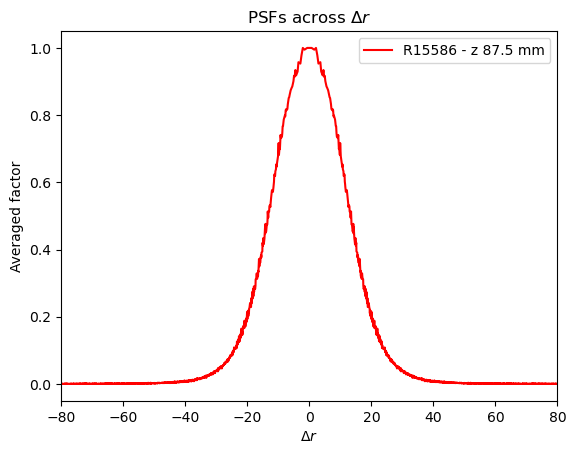

287.5


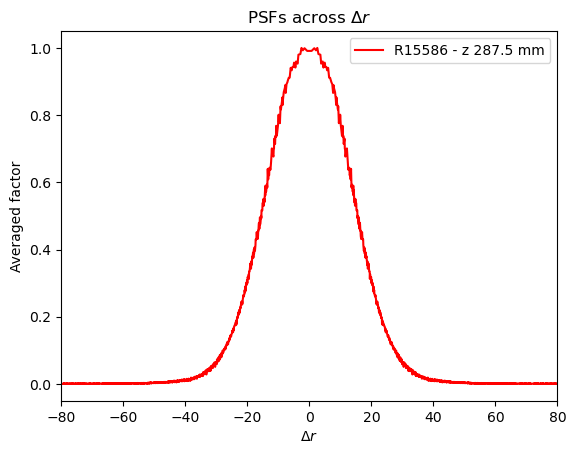

487.5


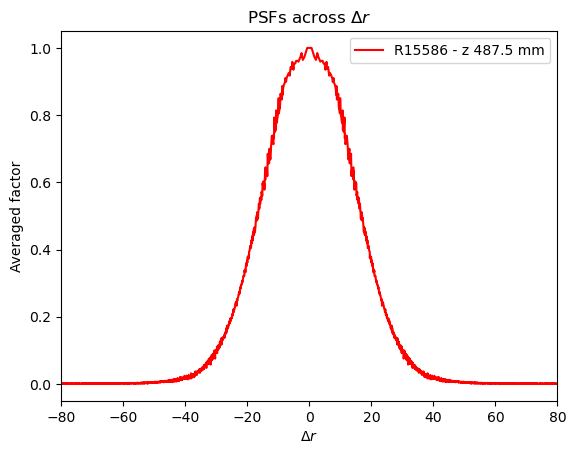

687.5


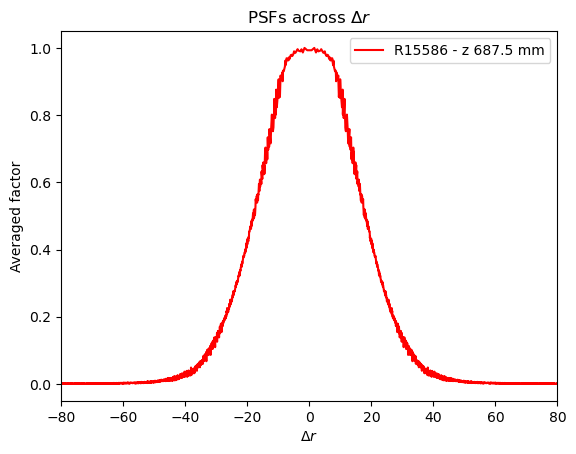

887.5


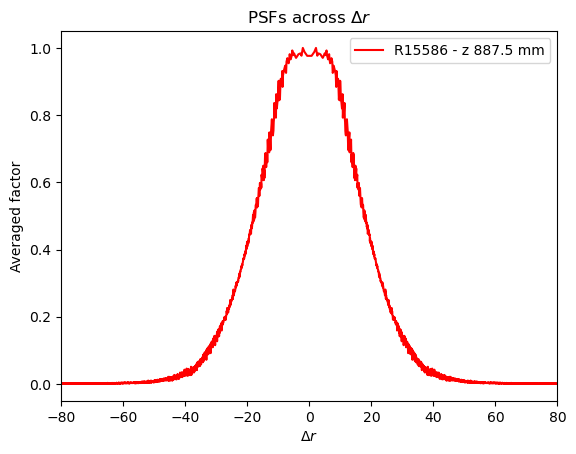

1087.5


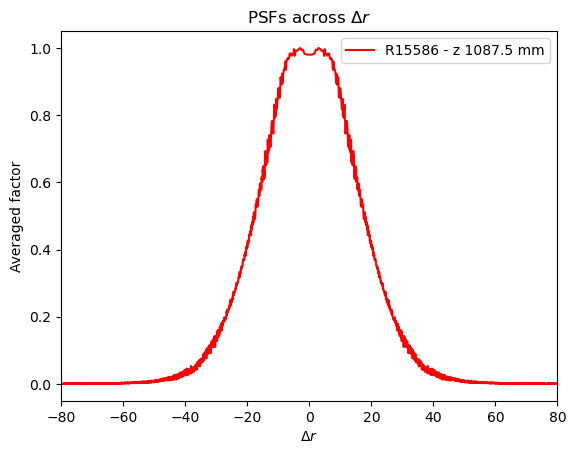

In [46]:
norm = True
for i in [87.5, 287.5, 487.5, 687.5, 887.5, 1087.5]:
    print(i)
    func.create_plots_psf(psf_data_R15586, i, f'R15586 - z {i} mm', norm, color = 'red')
    ## one mm psf
    plt.xlabel("$\Delta r$")
    plt.ylabel("Averaged factor")
    plt.xlim([-80, 80])
    #plt.yscale('log')
    plt.legend()
    plt.title("PSFs across $\Delta r$")
    plt.show()

# apply gaussian kernel in convolution to each step

In [48]:
!pip install opencv-python

     |████████████████████████████████| 67.0 MB 17.5 MB/s eta 0:00:01     |███████████████████▍            | 40.6 MB 14.2 MB/s eta 0:00:02


In [49]:
import cv2 as cv

Text(0, 0.5, 'factor')

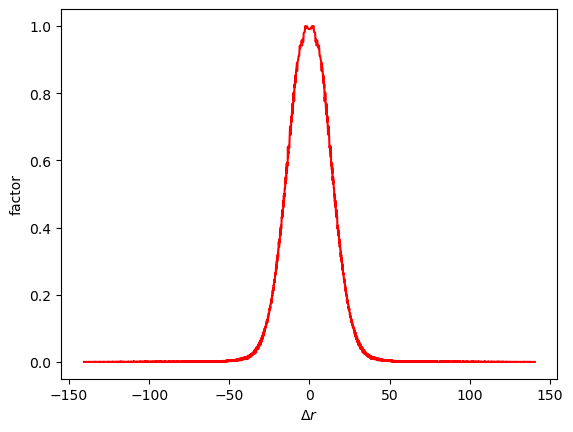

In [55]:
# lets select a specific z to compare to

z_check = 287.5
psf_z_data = psf_data_R15586[psf_data_R15586.z == z_check]
func.create_plots_psf(psf_z_data, z_check, f'R15586 - z {z_check} mm', norm, color = 'red')
plt.xlabel('$\Delta r$')
plt.ylabel('factor')

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.11698914e-04, 0.00000000e+00],
       [0.00000000e+00, 1.01718893e-05, 0.00000000e+00, ...,
        0.00000000e+00, 8.78557066e-05, 0.00000000e+00],
       [1.22793143e-04, 0.00000000e+00, 0.00000000e+00, ...,
        7.80666704e-06, 8.84431635e-05, 1.13756991e-04],
       ...,
       [3.85087853e-05, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 4.44242962e-06, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

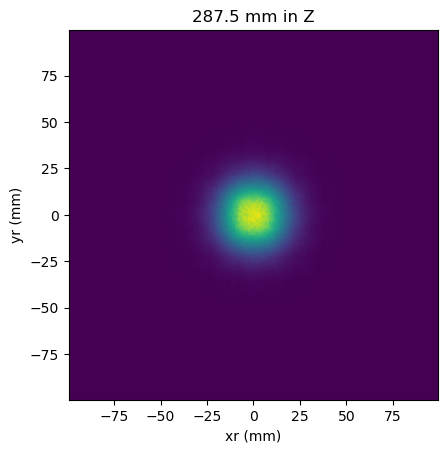

In [ ]:
# take factor as xy grid
nx = psf_z_data.xr.unique().size
ny = psf_z_data.yr.unique().size
matrix = psf_z_data.factor.values.reshape(nx, ny)
xyrange = (psf.xr.min(), psf.xr.max())
plt.imshow(matrix, extent=(*xyrange, *xyrange), origin="lower", aspect="equal")
plt.xlabel("xr (mm)")
plt.ylabel("yr (mm)")
plt.title(f'{z_check} mm in Z')

In [ ]:
# attempt the smoothing
print(len(matrix), len(matrix[0]))


# averaging factor?
av_factor = 5

# generate kernel
kernel = np.ones((av_factor, av_factor),np.float32)/(av_factor**2)
dst = cv.filter2D(matrix,-1,kernel)

200 200


Text(0.5, 1.0, '287.5 mm in Z')

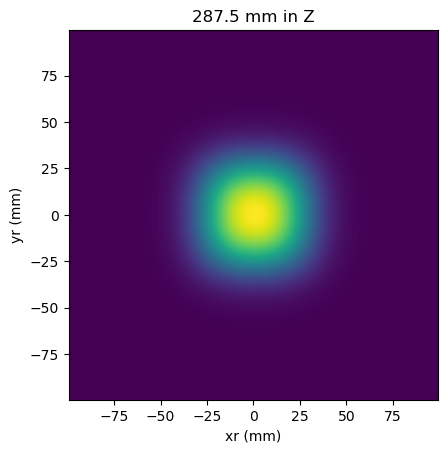

In [81]:
plt.imshow(dst, extent=(*xyrange, *xyrange), origin="lower", aspect="equal")
plt.xlabel("xr (mm)")
plt.ylabel("yr (mm)")
plt.title(f'{z_check} mm in Z')

In [ ]:
# Create a DataFrame from the matrix
xr_vals = np.linspace(xyrange[0], xyrange[1], nx)
yr_vals = np.linspace(xyrange[0], xyrange[1], ny)
xr, yr = np.meshgrid(xr_vals, yr_vals, indexing='ij')

# Flatten the arrays and create a DataFrame
reversed_df = pd.DataFrame({
    'xr': xr.flatten(),
    'yr': yr.flatten(),
    'factor': dst.flatten(),
    'z': z_check
})

display(reversed_df)



,xr,yr,factor,z
0,-99.5,-99.5,0.000000,287.5
1,-99.5,-98.5,0.000000,287.5
2,-99.5,-97.5,0.000000,287.5
3,-99.5,-96.5,0.000003,287.5
4,-99.5,-95.5,0.000000,287.5
...,...,...,...,...
39995,99.5,95.5,0.000014,287.5
39996,99.5,96.5,0.000000,287.5
39997,99.5,97.5,0.000000,287.5
39998,99.5,98.5,0.000000,287.5


,rr,factor
0,0.707107,0.203922
1,1.581139,0.205569
2,2.121320,0.204291
3,2.549510,0.205753
4,2.915476,0.201999
...,...,...
3409,138.609163,0.000030
3410,139.300036,0.000025
3411,139.307214,0.000034
3412,140.008928,0.000014


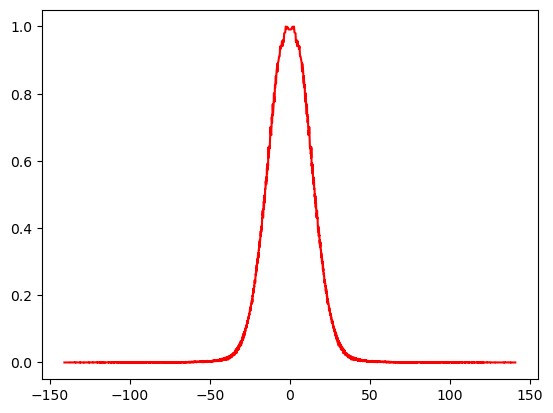

In [83]:
func.create_plots_psf(reversed_df, z_check, f'SMOOTHED', norm, color = 'red')


Text(0.5, 1.0, 'z - 287.5 mm')

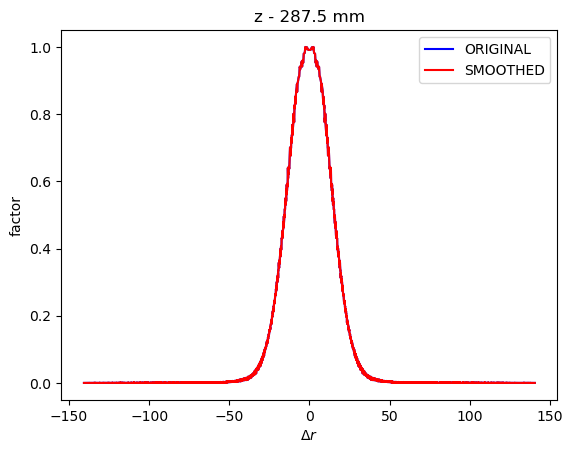

In [84]:
func.create_plots_psf(psf_z_data, z_check, f'ORIGINAL', norm, color = 'blue')
func.create_plots_psf(reversed_df, z_check, f'SMOOTHED', norm, color = 'red')
plt.xlabel('$\Delta r$')
plt.ylabel('factor')
plt.legend()
plt.title(f'z - {z_check} mm')